In [34]:
# Processing for EKF for Semantic Tracking

from  PIL  import  Image
from lang_sam import LangSAM
import os
import cv2
import numpy as np


def load_images_from_folder(folder):
    # Get the directory path
    directory = os.path.join('data', folder)

    # Load images from the directory
    images = []
    for filename in os.listdir(directory):
        if filename.endswith(".jpg") or filename.endswith(".png"):
            images.append(os.path.join(directory, filename))
        else:
            continue

    # Organize images by name
    images.sort()

    # Open every image and add to the list
    image_list = []
    for image in images:
        image_list.append(Image.open(image).convert("RGB"))

    return image_list

def images_to_video(images, output_path, fps=30):
    """
    Converts a collection of PIL images to a video.

    Args:
        images (list): A list of PIL images to be converted to a video.
        output_path (str): The path of the output video file.
        fps (int, optional): Frames per second of the output video (default is 30).

    Returns:
        None
    """
    # Get the dimensions of the first image
    width, height = images[0].size

    # Define the video codec, output file, and frames per second (fps)
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    # Convert PIL images to OpenCV format and write to the video
    for image in images:
        frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
        video.write(frame)

    # Release the video writer
    video.release()


def bounding_boxes_to_pose(bounding_boxes, image_width, image_height):
    poses = []

    
    for box in bounding_boxes:
        # Convert box coordinates to pose using YOLO
        x, y, w, h = box
        center_x = x + w / 2
        center_y = y + h / 2
        pose_measurement = [center_x / image_width, center_y / image_height, w / image_width, h / image_height]

        # Add pose to list of poses
        poses.append(np.array(pose_measurement))

        
    return poses


def pose_to_bounding_box(pose, image_width, image_height):
    # Convert pose to bounding box using YOLO
    center_x, center_y, w, h = pose
    x = center_x * image_width - w / 2
    y = center_y * image_height - h / 2
    bounding_box = [x, y, w, h]

    return bounding_box


def get_frame_bounding_boxes(image_list, text_prompt):
    """
    Get the bounding boxes of every frame in a list of images along with the predicted masks.

    Args:
        image_list (list): List of PIL images.
        text_prompt (str): Text prompt for model prediction.

    Returns:
        List of tuples: Each tuple contains the masks and bounding boxes for a single image.
                       The masks are a list of predicted masks for each frame in the image.
                       The bounding boxes are a list of bounding boxes for each frame in the image.
    """
    model = LangSAM()

    results = []

    for image_pil in image_list:
        # Get masks, boxes, phrases, and logits using LangSAM model
        masks, boxes, phrases, logits = model.predict(image_pil, text_prompt)


        masks = masks.numpy()
        poses = boxes.numpy()
        logits = logits.numpy()

        results.append((masks, poses, logits))
        print("logits are ", logits) 
        print("phrases are ", phrases)

        # PRINT HOW MANY MASKS THERE ARE
        print("There are ", len(masks), " masks")


    return results




In [51]:
# Import List
folder = 'skate_is'
image_list = load_images_from_folder(folder)

# Get Bounding Boxes
text_prompt = 'shoes'
results = get_frame_bounding_boxes(image_list, text_prompt)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from /Users/omoruyiatekha/.cache/huggingface/hub/models--ShilongLiu--GroundingDINO/snapshots/a94c9b567a2a374598f05c584e96798a170c56fb/groundingdino_swinb_cogcoor.pth 
 => _IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])


/Users/omoruyiatekha/opt/anaconda3/lib/python3.8/site-packages/transformers/modeling_utils.py:874: FutureWarning: The `device` argument is deprecated and will be removed in v5 of Transformers.
  warnings.warn(
/Users/omoruyiatekha/opt/anaconda3/lib/python3.8/site-packages/torch/utils/checkpoint.py:31: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


logits are  [0.3483781  0.46474302 0.42006108]
phrases are  ['shoes', 'shoes', 'shoes']
There are  3  masks
logits are  [0.49231994 0.40615344 0.4136619 ]
phrases are  ['shoes', 'shoes', 'shoes']
There are  3  masks
logits are  [0.41094843 0.38784006 0.44201666]
phrases are  ['shoes', 'shoes', 'shoes']
There are  3  masks


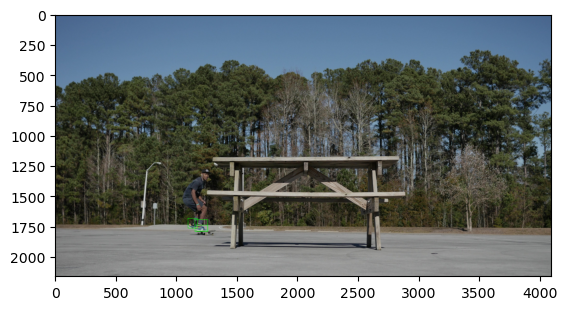

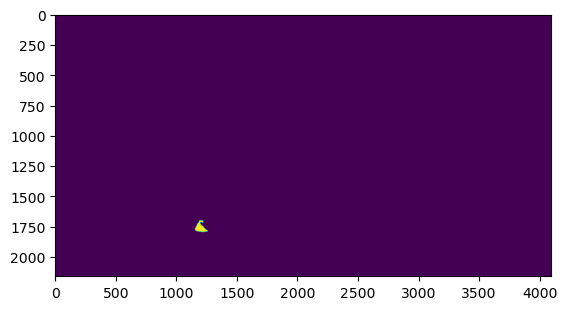

In [11]:
# Apply the mask to the image and plot them 
import matplotlib.pyplot as plt
masked_Images = []
for i in range(len(image_list)):
    image_array = np.asarray(image_list[i])
    for box in results[i][1]:
        box = box.int().tolist()
        image_array = cv2.rectangle(image_array, (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)

# Plot the first image with the bounding box
plt.imshow(image_array)
plt.show()

# using the results plot a mask
for i in range(len(image_list)):
    image_array = np.asarray(image_list[i])
    for mask in results[i][0]:
        mask = mask.int().tolist()
        
        plt.imshow(mask)



In [50]:
results[1][1]

# convert bounding boxes to poses
for result in results:
    print(bounding_boxes_to_pose(result[1], 4096, 2160))

[array([0.37718929, 0.99944068, 0.2883426 , 0.82785192])]
[array([0.38896994, 1.00073287, 0.29594257, 0.82914813])]
[array([0.40158179, 1.00215932, 0.30554226, 0.82670723])]


In [43]:
print(len(results))

3


In [80]:


# Here I will create an EKF function to track the bounding boxes, and then I will create a Multi-Hypothesis EKF to track objects using the probabilities of the masks

class EKF:

    """
    Args: x: state vector, P: covariance matrix, F: state transition matrix, Q: process noise covariance matrix, H: measurement matrix, R: measurement noise covariance matrix
    """

    def __init__(self, mu, sigma, F, Q, H, R, dt):
        self.mu = mu
        self.sigma = sigma
        self.F = F
        self.Q = Q
        self.H = H
        self.R = R
        self.dt = dt

    def predict(self):
        self.x = self.F @ self.mu
        self.sigma = self.F @ self.sigma @ self.F.T + self.Q

    def update(self, z):

        innovation = z - self.H @ self.mu
        K = self.sigma @ self.H.T @ np.linalg.inv(self.H @ self.sigma @ self.H.T + np.random.multivariate_normal(np.zeros(4), self.R))
        # mu = mu + K @ y, sigma = (I - K @ H) @ sigma
        self.mu = self.mu + K @ innovation
        self.sigma = self.sigma - K @ self.H @ self.sigma


def f(x, dt):
    # State transition function, for constant velocity model, for pose {x,y,w,h} and velocity {vx,vy,vw,vh}
    # mu = [x, y, w, h, vx, vy, vw, vh]

    F = np.array([[1, 0, 0, 0, dt, 0, 0, 0],
                    [0, 1, 0, 0, 0, dt, 0, 0],
                    [0, 0, 1, 0, 0, 0, dt, 0],
                    [0, 0, 0, 1, 0, 0, 0, dt],
                    [0, 0, 0, 0, 1, 0, 0, 0],
                    [0, 0, 0, 0, 0, 1 ,0, 0],
                    [0, 0, 0, 0, 0, 0, 1 ,0],
                    [0, 0, 0, 0, 0, 0, 0 ,1]])
    return F @ x

def h(x):
    # Measurement function, for pose {x,y,w,h}
    # mu = [x, y, w, h]
    # H is a 4 x 8 matrix that maps the state vector to the measurement vector
    H = np.array([[1, 0, 0, 0, 0, 0, 0, 0],
                    [0, 1 ,0, 0, 0, 0, 0, 0],
                    [0, 0, 1 ,0, 0, 0, 0, 0],
                    [0, 0, 0, 1 ,0, 0, 0, 0]])
    
    return H 

def computeVelocity(x1, x2, dt):
    # Compute velocity between two poses
    # x1 = [x, y, w, h], x2 = [x, y, w, h]
    vx = (x2[0] - x1[0]) / dt
    vy = (x2[1] - x1[1]) / dt
    vw = (x2[2] - x1[2]) / dt
    vh = (x2[3] - x1[3]) / dt
    return np.array([vx, vy, vw, vh])


def MHEKF(results, dt):

    n = len(results)
    pose_measurements = []
    gamma = []
    sigma = np.eye(8) * 0.1 * dt
    trajectories = []
    alphas = []
    max_hypotheses = 10

    # converting the bounding boxes from results into poses
    for result in results:
        pose_measurements.append(bounding_boxes_to_pose(result[1], 4096, 2160))
        gamma.append(result[2])
    
    # Set initial state trajectories to first pose measurements and intialize velocity to 0

    paths = []
    for pose in pose_measurements[0]:
        trajectories.append([np.concatenate((pose, np.zeros(4)))])
    

    # Initialized wWights for Each Trajectory
    paths.append(trajectories)
    alphas = np.ones(len(trajectories)) / len(trajectories)
    

    # Initialize EKFs for Each Pose Measurements from 1 to n
    # The Goal Here is to iterate through all the images or frames in range 1 to n
    # Given these detections we want to estimate the path of the object for every ekf given our current 
    # trajectory guesses and the current pose measurements, and then we want to update the trajectory guesses
    # It functinos as a tree that branches out for every detection
    # given the similarity we use the MH-EKF to update the trajectory guesses, and remove the ones that are not likely


    for i in range(1, n):

        # Initialize Trajectories for the Current Frame
        new_trajectories = []
        new_alphas = []

        # For every trajectory
        for traj, alpha in zip(trajectories, alphas):

            mu_prev = traj[-1]

            # Look at every pose measurement for the current frame
            for j, pose in enumerate(pose_measurements[i]):

                # For the current trajectory and the pose within the pose_measurements
                mu = np.concatenate((pose, computeVelocity(mu_prev, pose, dt)))
                ekf = EKF(mu, sigma, f(mu, dt), np.eye(8) * 0.1 * dt, h(mu), np.eye(4) * 0.1, dt)

                # Predict and Update for Every Possible Next Pose, Creating New Trajectories
                ekf.predict()
                ekf.update(pose)

                # Use the Gammas to calculate the new weight for the trajectory
                new_alpha = alpha * gamma[i][j]
                new_alphas.append(new_alpha)
                new_trajectories.append(traj + [ekf.mu])

        # Normalize the Alphas
        new_alphas = new_alphas / np.sum(new_alphas)

        # Prune Unlikely Trajectories
        # This is done by removing the trajectories with the lowest weights
        # We can do this by sorting the alphas and then removing the trajectories with the lowest alphas
        
        if len(new_alphas) > max_hypotheses:

            # Sort the Alphas and Trajectories
            sorted_alphas = np.argsort(new_alphas)
            sorted_trajectories = np.array(new_trajectories)[sorted_alphas]

            # Remove the Trajectories with the Lowest Alphas
            new_alphas = new_alphas[sorted_alphas]
            new_trajectories = sorted_trajectories[-max_hypotheses:]

            # Normalize the Alphas Again
            new_alphas = new_alphas / np.sum(new_alphas)

        # Update the Trajectories and Alphas
        trajectories = new_trajectories
        alphas = new_alphas

        # Print how many trajectories there are for each frame
        print("There are ", len(trajectories), " trajectories for frame ", i)


MHEKF(results, 1/30)





gamma is  0.46474302
There are  9  trajectories for frame  1
There are  10  trajectories for frame  2
